## **Install and import libraries**

**Install Python libraries**

In [1]:
!pip install sklearn
!pip install pyyaml==5.4.1
!pip install contractions
!pip3 install catboost
!pip install imblearn

In [2]:
conda install -c conda-forge wordcloud=1.8.1

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


**Import Python libraries**

In [93]:
# Exploratory Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.figure_factory as ff

# Text Pre-processing
import contractions
import re
import string
import nltk
nltk.download('punkt')
nltk.download('brown')
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# # Data processing libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# Hyperparameter tuning with grid search with cross validation
from sklearn.model_selection import GridSearchCV

# Machine Learning Algorithms
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve

[nltk_data] Downloading package punkt to /Users/golf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to /Users/golf/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/golf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/golf/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Nice display
from IPython.display import HTML
def pretty_print_df(value_counts_):
  display(HTML(pd.DataFrame(value_counts_).to_html()))

import warnings
warnings.filterwarnings('ignore')

## **Load the dataset (Amazon Reviews)**

In [5]:
# Load the dataset (Amazon Reviews)
dataset = pd.read_csv('.../Task 4 - “Amazon reviews” dataset/processed_reviews_split_surnamesR_minimal.csv')
dataset.head(10)

,review_id,text,verified,review_score,product_category
0,product_review_000000,I am one of those people who had Gran Turismo ...,False,1.0,video_games
1,product_review_000001,This game is awful for several reasons.\n1. T...,False,1.0,video_games
2,product_review_000002,This case is great for travel with the 3Ds or ...,False,5.0,video_games
3,product_review_000003,My go-to mic cable for quite a few years now. ...,True,5.0,musical_instruments
4,product_review_000004,The left one falls fairly frequently even when...,True,4.0,video_games
5,product_review_000005,I've played a lot of strings. These are what ...,True,5.0,musical_instruments
6,product_review_000006,Love these things.. Love Amazon,True,5.0,video_games
7,product_review_000007,This is a standard piece of equipment that mos...,True,-1.0,musical_instruments
8,product_review_000008,The D'Addario half-round jazz light strings su...,True,-1.0,musical_instruments
9,product_review_000009,"The reviews were so negative, I was scared to ...",True,5.0,video_games


## **Data quality assessment and Exploratory Data Analysis**
Explore the data to find out any issues

In [6]:
# Dataset information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32917 entries, 0 to 32916
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         32917 non-null  object 
 1   text              32908 non-null  object 
 2   verified          32811 non-null  object 
 3   review_score      32917 non-null  float64
 4   product_category  32011 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [7]:
# Summary statistics for numerical features
dataset.describe()

,review_score
count,32917.000000
mean,4.090440
std,1.434135
min,-1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [8]:
# List all categorical features
categorical_columns = ['verified', 'review_score',	'product_category']

# Count the categories for each feature
for col in categorical_columns:
  print(f"Categories and number of occurrences for '{col}'")
  pretty_print_df(dataset[col].value_counts())
  print()

Categories and number of occurrences for 'verified'


,verified
True,23316
False,9495



Categories and number of occurrences for 'review_score'


,review_score
5.0,19298
4.0,6182
3.0,3123
1.0,1849
2.0,1558
-1.0,907



Categories and number of occurrences for 'product_category'


,product_category
video_games,21577
musical_instruments,10434


**Observation of the unusual data**

The review score should not be negative numbers (-1.0, invalid). Therefore, I am not going to use the data which have the review score equal to -1.0, including the verified column because I would like to remove all missing values and I want to make sure that removing the data will not affect to the prediction so much.

In [9]:
# Count the missing values
print(dataset.isnull().sum())

review_id             0
text                  9
verified            106
review_score          0
product_category    906
dtype: int64


In [10]:
# Count the duplicated values
print('Total duplicated values in the review_id column: ', dataset.duplicated(subset = ['review_id']).sum())
print('Total duplicated values in the text column: ', dataset.duplicated(subset = ['text']).sum())

Total duplicated values in the review_id column:  0
Total duplicated values in the text column:  2749


**Managing the unusual data**

In [11]:
# Remove the verified column
dropcolumn_dataset = dataset.drop(columns=['verified'])

# Remove all rows that contain at least one missing value
dropna_dataset = dropcolumn_dataset.dropna()

# Remove all rows where review_score is -1.0
reduced_dataset = dropna_dataset[dropna_dataset.review_score != -1]

# Remove the duplicated data
clean_dataset = reduced_dataset.drop_duplicates(subset=['text'])

In [12]:
print(f'Length of the original dataset: {len(dataset)}')
print(f'Dataset length after data cleaning: {len(clean_dataset)}')
clean_dataset.head()

Length of the original dataset: 32917
Dataset length after data cleaning: 30167


,review_id,text,review_score,product_category
0,product_review_000000,I am one of those people who had Gran Turismo ...,1.0,video_games
1,product_review_000001,This game is awful for several reasons.\n1. T...,1.0,video_games
2,product_review_000002,This case is great for travel with the 3Ds or ...,5.0,video_games
3,product_review_000003,My go-to mic cable for quite a few years now. ...,5.0,musical_instruments
4,product_review_000004,The left one falls fairly frequently even when...,4.0,video_games


In [13]:
# Count the categories for each feature
new_categorical_columns = ['review_score',	'product_category']
for col in new_categorical_columns:
  print(f"Categories and number of occurrences for '{col}'")
  pretty_print_df(clean_dataset[col].value_counts())
  print()

Categories and number of occurrences for 'review_score'


,review_score
5.0,18168
4.0,5833
3.0,2951
1.0,1754
2.0,1461



Categories and number of occurrences for 'product_category'


,product_category
video_games,20328
musical_instruments,9839


In [14]:
# Confirm the missing values
print('The missing values')
print(clean_dataset.isnull().sum(),'\n')

# Confirm the duplicated values
print('Total duplicated values in the review_id column: ', clean_dataset.duplicated(subset = ['review_id']).sum())
print('Total duplicated values in the text column: ', clean_dataset.duplicated(subset = ['text']).sum(),'\n')

# Dataset information after reducing the missing values
clean_dataset.info()

The missing values
review_id           0
text                0
review_score        0
product_category    0
dtype: int64 

Total duplicated values in the review_id column:  0
Total duplicated values in the text column:  0 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30167 entries, 0 to 32916
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   review_id         30167 non-null  object 
 1   text              30167 non-null  object 
 2   review_score      30167 non-null  float64
 3   product_category  30167 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


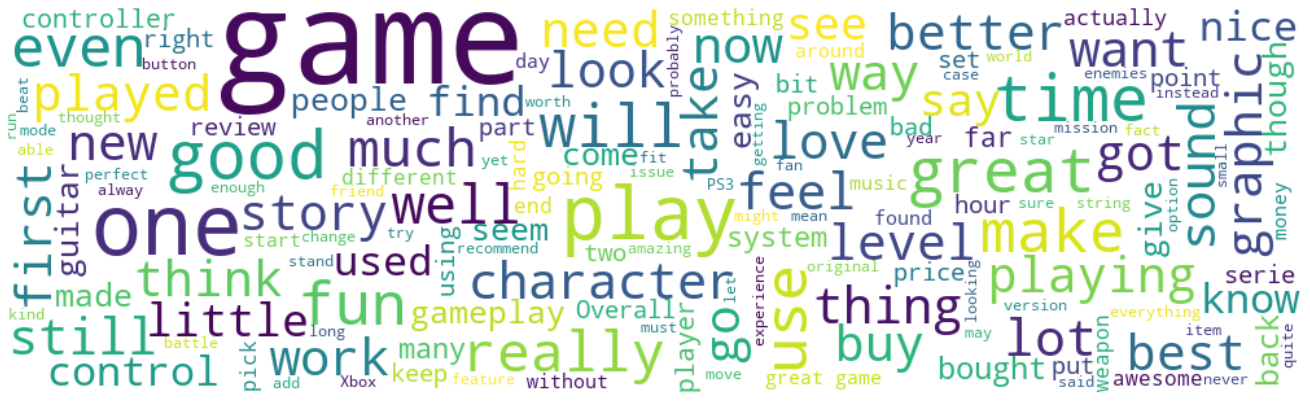

In [15]:
# Generate a word cloud to observe the most occurring words in the reviews
def wordcloud(clean_dataset):
    wordcloud = WordCloud(width = 1000, height = 300,
                          background_color ='white',
                          max_font_size = 100, 
                          min_font_size = 10).generate(" ".join(clean_dataset.values))                      
    plt.figure(figsize = (18, 6), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

# Apply the wordcloud funtion with clean_dataset['text']
wordcloud(clean_dataset['text'])

In [16]:
# Please ingore this line of coding, it was used to export the ‘exclusions_dataset_taskX.csv’ file only
"""
clean_dataset['excluded'] = pd.Series([0 for x in range(len(dataset.index))])
clean_dataset['reason_for_exclusion'] = pd.Series(['N/A' for x in range(len(dataset.index))])

frames = [clean_dataset, dataset]
result = pd.concat(frames)
result_dataset = result.drop_duplicates(subset=['review_id'])
result_dataset = result_dataset.drop(columns=['verified'])

from google.colab import files
result_dataset.to_csv('exclusions_dataset_task4.csv') 
files.download('exclusions_dataset_task4.csv')
"""

"\nclean_dataset['excluded'] = pd.Series([0 for x in range(len(dataset.index))])\nclean_dataset['reason_for_exclusion'] = pd.Series(['N/A' for x in range(len(dataset.index))])\n\nframes = [clean_dataset, dataset]\nresult = pd.concat(frames)\nresult_dataset = result.drop_duplicates(subset=['review_id'])\nresult_dataset = result_dataset.drop(columns=['verified'])\n\nfrom google.colab import files\nresult_dataset.to_csv('exclusions_dataset_task4.csv') \nfiles.download('exclusions_dataset_task4.csv')\n"

## **Text Pre-processing**

**1. Resolve the contractions in English**
I use the contractions package from https://github.com/kootenpv/contractions to resolve contractions and slang in English such as I've -> I have, etc. 

In [17]:
clean_dataset['processed_text'] = clean_dataset['text'].map(lambda docs:contractions.fix(docs))

**2. Convert into lowercase words and remove HTML tags, including URLs**

In [18]:
def text_processing(document):
    # Convert uppercase words into lowercase words
    document = str(document)
    document = document.lower()

    # Remove HTML tags using RegEx
    document = document.replace('{html}', '') 
    remove_tag = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    remove_tag_text = re.sub(remove_tag, '', document)

    # Remove URLs
    remove_url = re.sub(r'https?://\S+|www\.\S+', '', remove_tag_text)
    
    # Remove number
    remove_num = re.sub('[0-9]+', '', remove_url)
    
    return remove_num

clean_dataset['processed_text'] = clean_dataset['processed_text'].map(lambda docs:text_processing(docs))

**3. Tokenization**

In [19]:
clean_dataset['processed_text'] = clean_dataset['processed_text'].map(word_tokenize)

**4. Remove stopwords**

In [20]:
stopwords_set = set(stopwords.words('english'))
clean_dataset['processed_text'] = clean_dataset['processed_text'].apply(lambda docs: [word for word in docs if word not in stopwords_set])

**5. Part of speech (POS) of English words in order to improve spelling and accuracy**

In [21]:
# More detail at https://www.nltk.org/book/ch05.html
wordtags = {"N":wn.NOUN, "V":wn.VERB, "J":wn.ADJ, "R":wn.ADV}

# Combining taggers of N-Gram Tagging
brown_tagged_sents = brown.tagged_sents(categories = 'news')
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(brown_tagged_sents, backoff = t0)
t2 = nltk.BigramTagger(brown_tagged_sents, backoff = t1)

def pos_tagger(docs, pos_tag_type = "pos_tag"):
    tagger = t2.tag(docs)
    tagger = [(word, wordtags.get(pos_tag[0])) 
    if pos_tag[0] in wordtags.keys() 
    else (word, wn.NOUN) 
    for (word, pos_tag) in tagger]
    return tagger

clean_dataset['processed_text'] = clean_dataset['processed_text'].apply(lambda docs: pos_tagger(docs))

**6. Lemmatization**

In [22]:
def lemmatizer(docs):
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(word, tag) for word, tag in docs]
    return lemmatized

clean_dataset['processed_text'] = clean_dataset['processed_text'].apply(lambda docs: lemmatizer(docs))

# Apply the removal of stopwords
clean_dataset['processed_text'] = clean_dataset['processed_text'].apply(lambda docs: [word for word in docs if word not in stopwords_set])

# Join words together
clean_dataset['processed_text'] = [' '.join(map(str, word)) for word in clean_dataset['processed_text']]

**7. Remove punctuation**

In [23]:
remove_punc = string.punctuation
def remove_punctuation(document):
    return document.translate(str.maketrans('', '', remove_punc))

clean_dataset['processed_text']=clean_dataset['processed_text'].apply(lambda docs: remove_punctuation(docs))

In [24]:
# Text after preprocessing
clean_dataset.head(10)

,review_id,text,review_score,product_category,processed_text
0,product_review_000000,I am one of those people who had Gran Turismo ...,1.0,video_games,one people gran turismo special addition h...
1,product_review_000001,This game is awful for several reasons.\n1. T...,1.0,video_games,game awful several reason control awful way...
2,product_review_000002,This case is great for travel with the 3Ds or ...,5.0,video_games,case great travel lite hold game extra stylu...
3,product_review_000003,My go-to mic cable for quite a few years now. ...,5.0,musical_instruments,goto mic cable quite year spiral shield easy ...
4,product_review_000004,The left one falls fairly frequently even when...,4.0,video_games,leave one fall fairly frequently even gameplay...
5,product_review_000005,I've played a lot of strings. These are what ...,5.0,musical_instruments,play lot string settle tone durability fee...
6,product_review_000006,Love these things.. Love Amazon,5.0,video_games,love thing love amazon
9,product_review_000009,"The reviews were so negative, I was scared to ...",5.0,video_games,review negative scared purchase game mac gam...
10,product_review_000010,Never played the game it was brought for a chi...,5.0,video_games,never play game bring child play leave feed ba...
11,product_review_000011,Hot Shots golf games has always been a fun cas...,5.0,video_games,hot shot golf game always fun casual take game...


**More Exploratory Data Analysis**

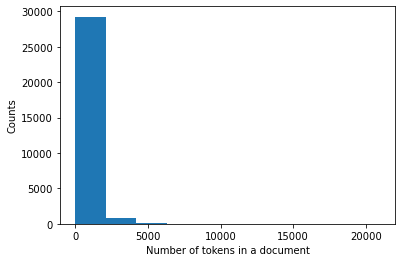

In [25]:
# Number of tokens in each document
processed = list((clean_dataset['processed_text']))
doc_tokens= []
for doc in processed:
  doc_tokens.append(len(doc))

# plot the distribution of lengths in an histogram
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(doc_tokens)
ax.set_xlabel('Number of tokens in a document')
_ =ax.set_ylabel('Counts')

5.0    18168
4.0     5833
3.0     2951
1.0     1754
2.0     1461
Name: review_score, dtype: int64


[]

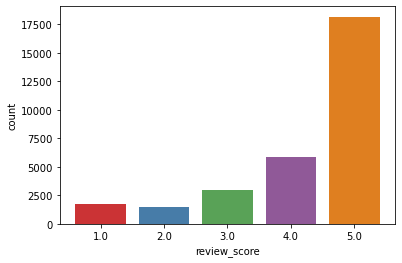

In [26]:
# Star Ratings
# Display total number
print(clean_dataset.review_score.value_counts())
sns.countplot(clean_dataset.review_score, palette = 'Set1')

# visualise the result
plt.plot()

video_games            20328
musical_instruments     9839
Name: product_category, dtype: int64


[]

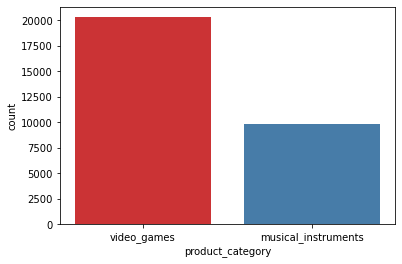

In [27]:
# Product categories
# Display total number
print(clean_dataset.product_category.value_counts())
sns.countplot(clean_dataset.product_category, palette = 'Set1')

# visualise the result
plt.plot()

[]

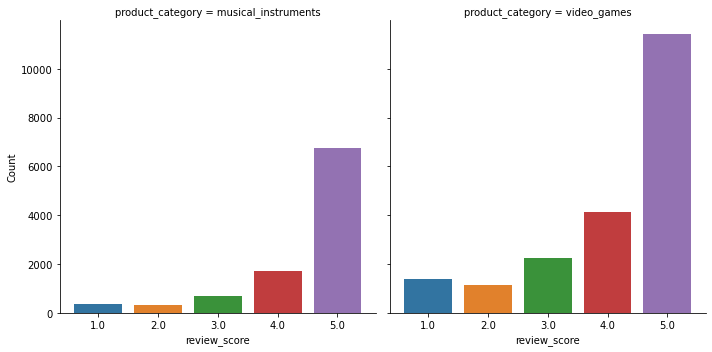

In [28]:
# Plot the relationship between Family Members and Response
df3 = clean_dataset.groupby(['review_score', 'product_category'])['review_id'].count().to_frame().rename(columns = {'review_id':'Count'}).reset_index()
graph3 = sns.catplot(x = 'review_score', y = 'Count', col = 'product_category',
                data = df3, kind = 'bar',
                height = 5, aspect = 1)

# visualise the result
plt.plot()

## **Task 1: Predict the number of star rating associated with the review**

### **Data Processing**

**Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer**

In [29]:
tf_idf = TfidfVectorizer(max_features = 50000, 
                         ngram_range = (1,3), 
                         analyzer = 'char',
                         stop_words='english',
                         min_df = 5)

# Fit transform
X = tf_idf.fit_transform(clean_dataset['processed_text'])
y = clean_dataset['review_score']

X.shape, y.shape

((30167, 7884), (30167,))

**Standardization**

In [30]:
scaler = StandardScaler(with_mean=False)
X = scaler.fit_transform(X)

**Undersampling technique for imbalance dataset**

In [31]:
# For experiment ONLY
"""
print(f'The original dataset shape : {Counter(y)}')

rus = RandomUnderSampler(random_state= 0 )
X_resampled, y_resampled = rus.fit_resample(X, y)

print(f'The dataset shape after oversampling {Counter(y_resampled)}')
"""

"\nprint(f'The original dataset shape : {Counter(y)}')\n\nrus = RandomUnderSampler(random_state= 0 )\nX_resampled, y_resampled = rus.fit_resample(X, y)\n\nprint(f'The dataset shape after oversampling {Counter(y_resampled)}')\n"

**Synthetic Minority Oversampling Technique (SMOTE) for imbalance dataset**

In [32]:
print(f'The original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print(f'The dataset shape after oversampling {Counter(y_smote)}')

The original dataset shape : Counter({5.0: 18168, 4.0: 5833, 3.0: 2951, 1.0: 1754, 2.0: 1461})
The dataset shape after oversampling Counter({1.0: 18168, 5.0: 18168, 4.0: 18168, 3.0: 18168, 2.0: 18168})


**Data Splitting**

In [33]:
# Split the dataste
x_train, x_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.2, stratify = y_smote, random_state = 42)

# Split the validation dataset
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train, y_train, test_size = 0.1, stratify = y_train, random_state=42)

In [34]:
x_train.shape, y_train.shape

((72672, 7884), (72672,))

### **Modelling**

**Model 1: Linear Support Vector Classification (LinearSVC)**

In [35]:
# Linear Support Vector Classification Algorithm 
linear_svc = LinearSVC(C = 5,
                       class_weight = 'balanced', 
                       random_state = 0,
                       tol = 1e-5)

# Fit the model 
linear_svc.fit(x_train, y_train)

# Prediction
linear_svc_predict = linear_svc.predict(x_test)

**Model 2: LinearSVC model on K-fold Cross Validation**

In [36]:
# K-fold Cross Validation
kfold = KFold(n_splits = 5, shuffle = True, random_state=0)

kfold_linear_svc = LinearSVC(C = 5,
                             class_weight = 'balanced',
                             random_state = 0, 
                             tol = 1e-5)

# Prediction
kfold_linear_svc_predict = cross_val_predict(kfold_linear_svc, x_train, y_train, cv = kfold)

**Model 3: Gradient Boosting**

In [37]:
# Gradient Boosting Classification Algorithm
gb = GradientBoostingClassifier(n_estimators = 10, 
                                learning_rate = 0.1,
                                random_state = 0)
# Fit the model
gb.fit(x_train, y_train)

# Prdiction
gb_predict = gb.predict(x_test)

### **Model Evaluation**

**Model 1 Evaluation: Linear Support Vector Classification (LinearSVC)**

In [39]:
# Accuracy score
acc_score_linearsvc = round(accuracy_score(y_test, linear_svc_predict) * 100, 5)
print(f'Accuracy score for the LinearSVC model: {acc_score_linearsvc}%\n')

# Classification report
print(classification_report(y_test, linear_svc_predict))

Accuracy score for the LinearSVC model: 82.13893%

              precision    recall  f1-score   support

         1.0       0.90      0.98      0.94      3634
         2.0       0.91      0.99      0.95      3633
         3.0       0.84      0.86      0.85      3634
         4.0       0.69      0.75      0.72      3634
         5.0       0.74      0.52      0.61      3633

    accuracy                           0.82     18168
   macro avg       0.82      0.82      0.81     18168
weighted avg       0.82      0.82      0.81     18168



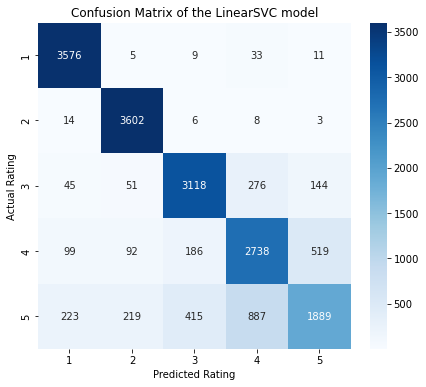

In [45]:
# Confusion matrix of the LinearSVC model
linear_svc_cm = confusion_matrix(y_test, linear_svc_predict)
linear_svc_cm_df = pd.DataFrame(linear_svc_cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(7,6))
sns.heatmap(linear_svc_cm_df, annot=True, fmt= '.0f', cmap='Blues')
plt.title('Confusion Matrix of the LinearSVC model')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
plt.show()

**Model 2 Evaluation: LinearSVC model on K-fold Cross Validation**

In [42]:
# Accuracy score
kfold_linear_svc_scores = cross_val_score(kfold_linear_svc, x_train, y_train, cv = kfold).round(5) 
print('Stratified cross-validation scores with linear kernel:\n\n{}'.format(kfold_linear_svc_scores))

Stratified cross-validation scores with linear kernel:

[0.81933 0.81108 0.81891 0.8101  0.81836]


In [43]:
# Average accuracy score
avg_acc_score = round(np.mean(kfold_linear_svc_scores) * 100, 5)
print(f'Accuracy score for the LinearSVC model with K-fold Cross Validation: {avg_acc_score}%\n')

Accuracy score for the LinearSVC model with K-fold Cross Validation: 81.5556%



In [44]:
# Classification report
print(classification_report(y_train, kfold_linear_svc_predict))

              precision    recall  f1-score   support

         1.0       0.88      0.98      0.93     14534
         2.0       0.91      0.98      0.94     14535
         3.0       0.81      0.87      0.84     14534
         4.0       0.72      0.73      0.72     14534
         5.0       0.72      0.52      0.61     14535

    accuracy                           0.82     72672
   macro avg       0.81      0.82      0.81     72672
weighted avg       0.81      0.82      0.81     72672



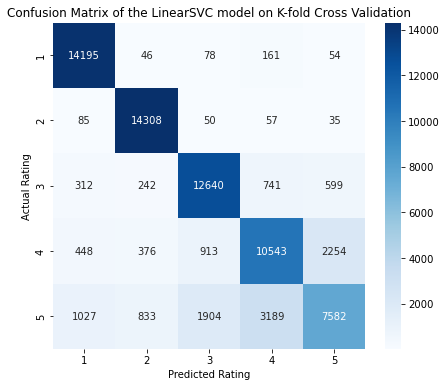

In [46]:
# Confusion matrix of the LinearSVC model on K-fold Cross Validation
kfold_svm_cm = confusion_matrix(y_train, kfold_linear_svc_predict)
kfold_svm_cm_df = pd.DataFrame(kfold_svm_cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(7,6))
sns.heatmap(kfold_svm_cm_df, annot=True, fmt= '.0f', cmap='Blues')
plt.title('Confusion Matrix of the LinearSVC model on K-fold Cross Validation')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
plt.show()

**Model 3 Evaluation: Gradient Boosting**

In [47]:
# Accuracy score
acc_score_gb = round(accuracy_score(y_test, gb_predict) * 100, 5)
print(f'Accuracy score for the Gradient Boosting model: {acc_score_gb}%\n')

# Classification report
print(classification_report(y_test, gb_predict))

Accuracy score for the Gradient Boosting model: 60.88727%

              precision    recall  f1-score   support

         1.0       0.72      0.63      0.67      3634
         2.0       0.87      0.58      0.70      3633
         3.0       0.82      0.52      0.64      3634
         4.0       0.47      0.52      0.49      3634
         5.0       0.46      0.79      0.59      3633

    accuracy                           0.61     18168
   macro avg       0.67      0.61      0.62     18168
weighted avg       0.67      0.61      0.62     18168



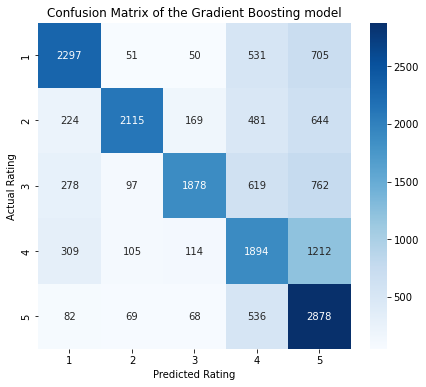

In [53]:
# Confusion matrix of the Multinomial Naive Bayes model
gb_cm = confusion_matrix(y_test, gb_predict)
gb_cm_df = pd.DataFrame(gb_cm,
                     index = ['1', '2', '3', '4', '5'], 
                     columns = ['1', '2', '3', '4', '5'])

plt.figure(figsize=(7,6))
sns.heatmap(gb_cm_df, annot=True, fmt= '.0f', cmap='Blues')
plt.title('Confusion Matrix of the Gradient Boosting model')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
plt.show()

**The comparison of accuracy scores**

[]

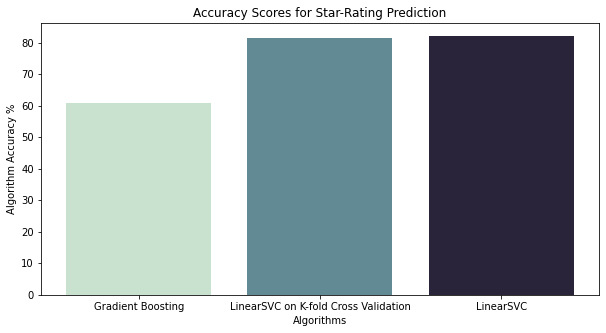

In [54]:
plt.style.use('seaborn-pastel')

x = ['Gradient Boosting',
     'LinearSVC on K-fold Cross Validation',
     'LinearSVC'
     ]

y = [acc_score_gb,
     avg_acc_score,
     acc_score_linearsvc
     ]

fig, ax = plt.subplots(figsize =(10,5))
sns.barplot(x = x, y = y, palette = 'ch:start=.3,rot=-.5')
plt.xlabel('Algorithms')
plt.ylabel('Algorithm Accuracy %')
plt.title('Accuracy Scores for Star-Rating Prediction')

# save the file
plt.savefig('/Users/golf/Documents/University of Greenwich/Term 2 - COMP1804 Applied Machine Learning/COMP1804 Coursework/Rating Accuracy', dpi=300, bbox_inches = 'tight')

#visualise the result
plt.plot()

In [55]:
# Visualise the accuracy score by table

results_df = pd.DataFrame(data=[[x[0], y[0]],
                                [x[1], y[1]],
                                [x[2], y[2]]
                               ], 
                          columns=['Model', 'Algorithms Accuracy %'])

results_df

,Model,Algorithms Accuracy %
0,Gradient Boosting,60.88727
1,LinearSVC on K-fold Cross Validation,81.55560
2,LinearSVC,82.13893


**The comparison of Confusion Matrices**

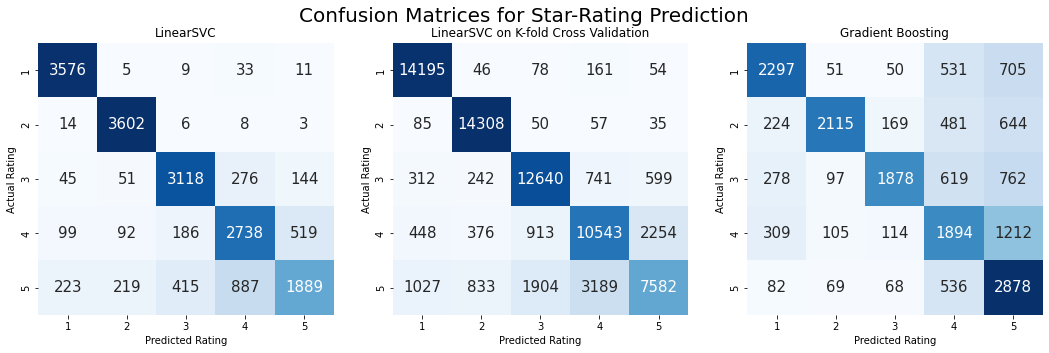

In [56]:
# Confusion matrices
linear_svc_cm = confusion_matrix(y_test, linear_svc_predict)
kfold_svm_cm = confusion_matrix(y_train, kfold_linear_svc_predict)
gb_cm = confusion_matrix(y_test, gb_predict)

# Visualise the result on the screen

plt.figure(figsize=(18,5))

plt.suptitle('Confusion Matrices for Star-Rating Prediction', fontsize = 20)
plt.subplots_adjust(wspace = 0.2, hspace = 0.2)

plt.subplot(1,3,1)
plt.title('LinearSVC')
linear_svc_df = pd.DataFrame(linear_svc_cm,
                             index = ['1', '2', '3', '4', '5'], 
                             columns = ['1', '2', '3', '4', '5'])
sns.heatmap(linear_svc_df , annot = True, cmap = 'Blues', fmt = 'd', cbar=False, annot_kws = {'size': 15})
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')

plt.subplot(1,3,2)
plt.title('LinearSVC on K-fold Cross Validation')
kfold_svm_cm_df = pd.DataFrame(kfold_svm_cm,
                                     index = ['1', '2', '3', '4', '5'], 
                                     columns = ['1', '2', '3', '4', '5'])
sns.heatmap(kfold_svm_cm_df, annot = True, cmap = 'Blues', fmt = 'd', cbar=False, annot_kws = {'size': 15})
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')

plt.subplot(1,3,3)
plt.title('Gradient Boosting')
gb_cm_df = pd.DataFrame(gb_cm,
                         index = ['1', '2', '3', '4', '5'], 
                         columns = ['1', '2', '3', '4', '5'])
sns.heatmap(gb_cm_df, annot = True, cmap = 'Blues', fmt = 'd', cbar = False, annot_kws = {'size': 15})
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')

# save the file
plt.savefig('/Users/golf/Documents/University of Greenwich/Term 2 - COMP1804 Applied Machine Learning/COMP1804 Coursework/Rating Confusion Matrices', dpi=300, bbox_inches = 'tight')

# visualise the result
plt.show()

**Predicted examples from the test dataset**

In [58]:
# Prediction
print('The predicted examples from the test dataset of the LinearSVC model\n', linear_svc_predict[0:10])


# Prediction
print('\nThe predicted examples from the test dataset of the LinearSVC model on K-fold cross validation\n', kfold_linear_svc_predict[0:10])

# Prediction
print('\nThe predicted examples from the test dataset of the Gradient Boosting model\n', gb_predict[0:10])

The predicted examples from the test dataset of the LinearSVC model
 [5. 3. 2. 4. 2. 3. 2. 3. 1. 3.]

The predicted examples from the test dataset of the LinearSVC model on K-fold cross validation
 [4. 5. 4. 5. 3. 4. 3. 5. 3. 4.]

The predicted examples from the test dataset of the Gradient Boosting model
 [5. 3. 2. 5. 5. 5. 2. 3. 1. 5.]
